# Aprendizado Profundo

# Processamento dos dados

# Redes Generativas Adversárias

# Caso de uso

In [1]:
var = """
TODO: 
- Mostrar imagem do mapa
- Análise estatística para modelagem com ARIMA
""" 

In [1]:
import glob
import importlib
import numpy as np
import pandas as pd
import plotting as p
import matplotlib.pyplot as plt
importlib.reload(p)
from sklearn.preprocessing import MinMaxScaler
plt.style.use("seaborn")

## Leitura e descrição dos dados

In [2]:
dataset = pd.read_csv("datasets/wikipedia_traffic.csv")
dataset = dataset.iloc[:1] # primeira coluna
dataset.fillna(0.0, inplace=True)
dataset.drop(labels=["Page"], axis="columns", inplace=True)
dataset = dataset.T
dataset.reset_index(inplace=True)
dataset.rename(columns={"index":"date", 0:"cnt"}, inplace=True)
dataset["date"] = pd.to_datetime(dataset["date"])
dataset.head()

,date,cnt
0,2015-07-01,18.0
1,2015-07-02,11.0
2,2015-07-03,5.0
3,2015-07-04,13.0
4,2015-07-05,14.0


In [3]:
lista_datas = dataset['date']

In [6]:
i = p.datetime.datetime(2015, 7, 1)
f = p.datetime.datetime(2016, 12,31)

In [37]:
dataset['cnt'].describe()

count    550.000000
mean      21.756364
std       29.390758
min        3.000000
25%       11.000000
50%       16.000000
75%       22.000000
max      490.000000
Name: cnt, dtype: float64

TODO: Breve explicação das colunas

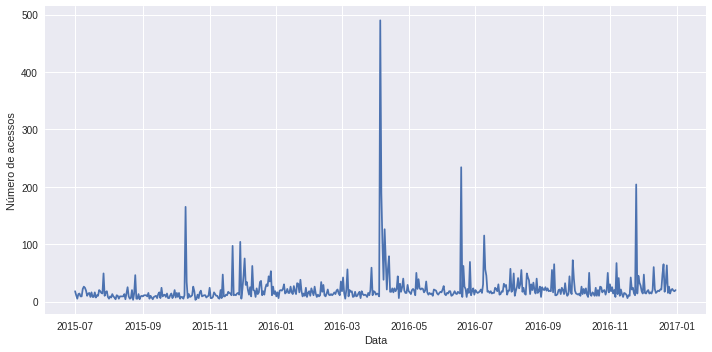

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lista_datas, dataset['cnt'])
ax.set_xlabel("Data")
ax.set_ylabel("Número de acessos")
plt.tight_layout()
plt.savefig("imagens/analises/webtraffic_total.eps")
# ax.set_title("Bicicletas alugdas entre 01/01/2011 e 31/12/2019");
# dataset[[0,1]].plot(ax=ax)

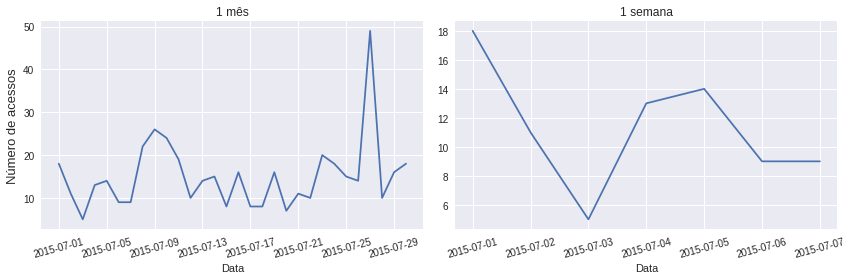

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[1].plot(lista_datas[:7], dataset['cnt'].iloc[:7])
ax[1].set_xlabel("Data")
ax[1].set_title("1 semana")
ax[1].tick_params('x', labelrotation=15)

ax[0].plot(lista_datas[:30], dataset['cnt'].iloc[:30])
ax[0].set_xlabel("Data")
ax[0].set_title("1 mês")
ax[0].tick_params('x', labelrotation=15)
ax[0].set_ylabel("Número de acessos", fontdict={"fontsize":13})
plt.tight_layout()
plt.savefig("imagens/analises/webtraffic_mes_semana.eps")

## Características esperadas

In [6]:
# ATUALIZAR A FUNÇÃO PRA PEGAR POR MÊS
real_data = dataset['cnt'].values.reshape(dataset.shape[0]//1, 1)
df_real = p.get_df(list_dates=lista_datas, data=dataset[['cnt']].values, timesteps=1, month=True)
dict_cnt_days, dict_cnt_wks  = p.count_daily(df_real)

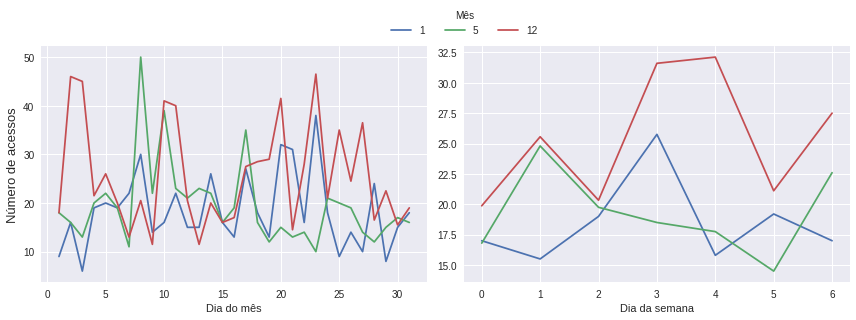

In [22]:
meses = np.arange(1,13)
meses = [1,5,12]
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
for m in meses:
    x_valores = dict_cnt_days[m]['x']
    lista_cnt = dict_cnt_days[m]['cnts']
    x_valores_wks = dict_cnt_wks[m]['x']
    lista_cnt_wks = dict_cnt_wks[m]['cnts']
    ax[0].plot(x_valores, lista_cnt, label="{}".format(m))
    ax[0].set_xlabel("Dia do mês")
    ax[1].plot(x_valores_wks, lista_cnt_wks, label="{}".format(m))
    ax[1].set_xlabel("Dia da semana")
ax[0].set_ylabel("Número de acessos", fontdict={"fontsize":13})
plt.tight_layout()
plt.legend(loc="center",bbox_to_anchor=(0,1.1), ncol=len(meses), title="Mês")
plt.savefig("imagens/analises/webtraffic_somas_intervalos.eps")

## Desafios de modelagem

- TODO: mostrar como sumarização não funciona (gerar dados falsos com a mesma métrica)

In [4]:
path_lista_fakes = glob.glob('datasets/generated/*.npy')

In [55]:
import numpy as np

In [28]:
a = np.load(path_lista_fakes[0])

In [27]:
dict_weeks = {i:p.get_list_wks(path_lista_fakes, lista_datas, 24, wk=i) for i in range(7)}

In [44]:
a = np.array(dict_weeks[0][0])

# Modelagem com o ARIMA

- Verificar se é estacionária
- Aplicar ajustes, se for necessário

In [30]:
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from statsmodels.tsa.arima.model import ARIMA

In [31]:
adf_test = pm.arima.stationarity.ADFTest(alpha=0.05)
treino = dataset['cnt'].iloc[:365].values
p_value, dif = adf_test.should_diff(treino)
print(p_value, dif)

0.01 False


In [32]:
%%time
pm_auto = pm.auto_arima(treino, seasonal=True, maxiter=5, start_p=2, max_p=3, start_q=2, max_q=3, stationary=True)

CPU times: user 1.37 s, sys: 789 ms, total: 2.16 s
Wall time: 1.24 s


In [33]:
order, seasonal_order = [pm_auto.order, pm_auto.seasonal_order]
print (order, seasonal_order)

(2, 0, 0) (0, 0, 0, 0)


In [35]:
# ajusta um modelo arima nos dados de treinamento
arima = ARIMA(treino, order=order, seasonal_order=seasonal_order)
res = arima.fit()

In [36]:
# gera 10 bases sinteticas com um modelo arima
for i in range(10):
    synth_arima = res.simulate(nsimulations=len(treino))
    np.save('datasets/generated/arima/webtraffic/arima_{}.npy'.format(i), synth_arima)

# GAN

In [ ]:
! pip install ydata-synthetic

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [ ]:
# Specific to TimeGANs
seq_len=24
n_seq = 1
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 28

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [11]:
scaler = MinMaxScaler().fit(treino.reshape(-1,1))
treino_scaled = scaler.transform(treino.reshape(-1,1))
treino_s = treino_scaled.reshape(len(treino)//24, 24, 1)

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(treino_s, train_steps=3000)

In [ ]:
synth.save("modelos/minicurso_bike.pkl")

In [ ]:
for i in range(10):
    synth_data = synth.sample(len(treino_s))
    np.save("datasets/generated/timegan/timegan_{}.npy".format(i), synth_data)

In [34]:
treino_s = MinMaxScaler().fit_transform(treino.reshape(-1,1))
treino_s = treino_s.reshape(treino.shape[0],1)

In [9]:
df_sample = p.get_df(lista_datas[:365*24], treino_s, timesteps=24)
dict_weeks_real = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

In [44]:
colors = ['orange','coral', 'fuchsia','purple', 'red','green','brown']

In [53]:
path_lista_fakes = glob.glob("datasets/generated/timegan/webtraffic/1/*.npy")

In [56]:
f1 = np.load(path_lista_fakes[0])

In [64]:
dataset.shape


(560, 1, 1)

In [66]:
def get_list_mes(model_samples, list_dates, m=1):
    lista_days = []
    lista_wks = []
    for f in model_samples:
        f = np.load(f)
        f = f.flatten()[:len(list_dates)]
        f = f.reshape(dataset.shape[0], 1)
        df_fk = p.get_df(list_dates=lista_datas, data=f, timesteps=1, month=True)
        dict_cnt_days_fk, dict_cnt_wks_fk  = p.count_daily(df_fk)        
        lista_days.append(dict_cnt_days_fk[m]['cnts'])
        lista_wks.append(dict_cnt_wks_fk[m]['cnts'])
    return lista_days, lista_wks

In [ ]:
dict_months_fakes = {i:get_list_mes(path_lista_fakes, lista_datas, m=m) for i in range(7)}

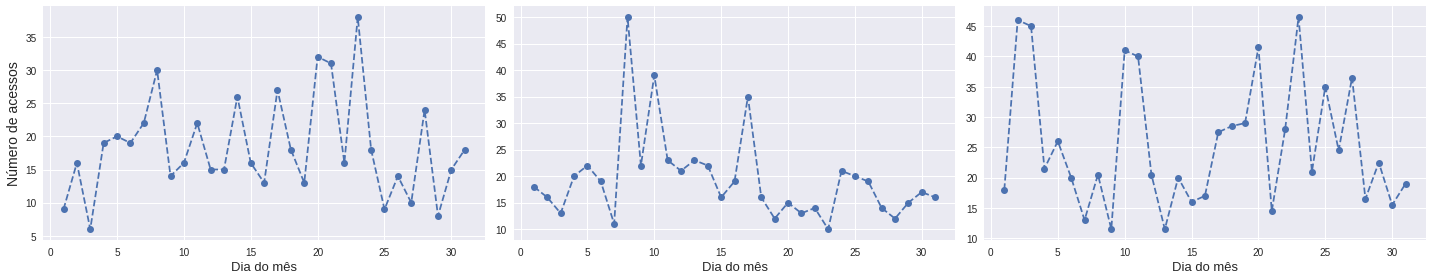

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(20,4))
for i, m in enumerate(meses):
    x = dict_cnt_days[m]['x']
    cnts = dict_cnt_days[m]['cnts']
    ax[i].plot(x,cnts, marker="o", ls='--')
    ax[i].set_xlabel("Dia do mês",fontdict={"fontsize":13})
ax[0].set_ylabel("Número de acessos", fontdict={"fontsize":14})
plt.tight_layout()

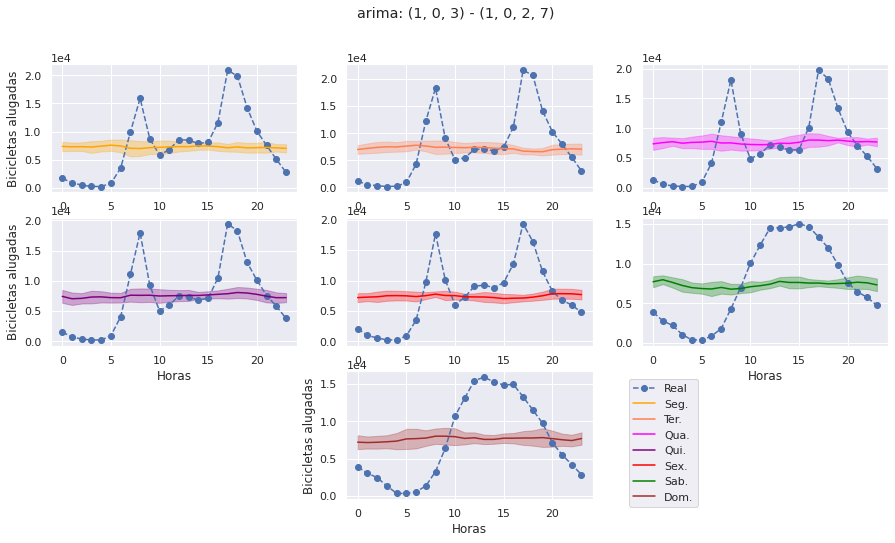

In [23]:
df_sample = p.get_df(lista_datas[:365*24], treino.reshape(-1,1 ), timesteps=24)
dict_weeks_real_arima = {wk:p.get_count(df_sample,wk,timestep=24, column='ts')['cnt_0'] for wk in range(7)} 

path_lista_fakes = glob.glob("datasets/generated/arima/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real_arima, bbox=(1.45, -0.1), figtitle="arima: {} - {}".format(order, seasonal_order), scaler=None)

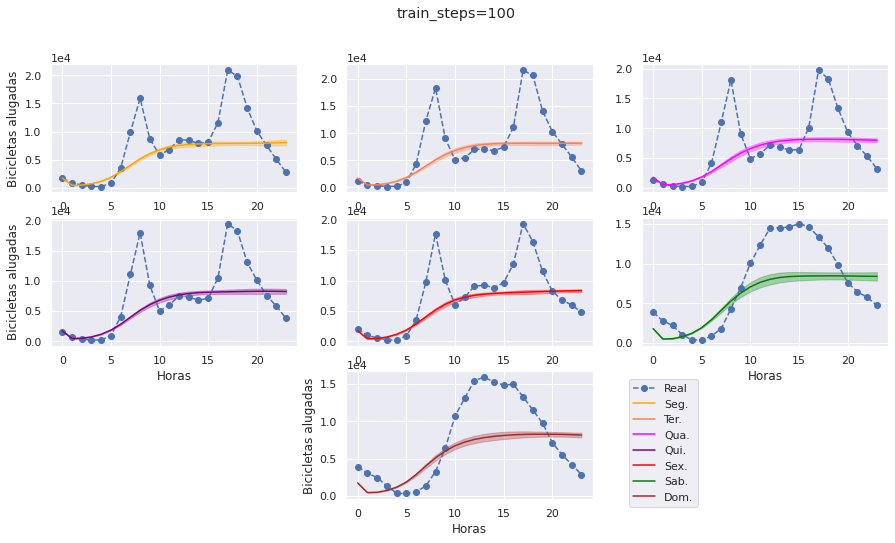

In [24]:
path_lista_fakes = glob.glob("datasets/generated/timegan/1/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), figtitle="train_steps=100", scaler=scaler)

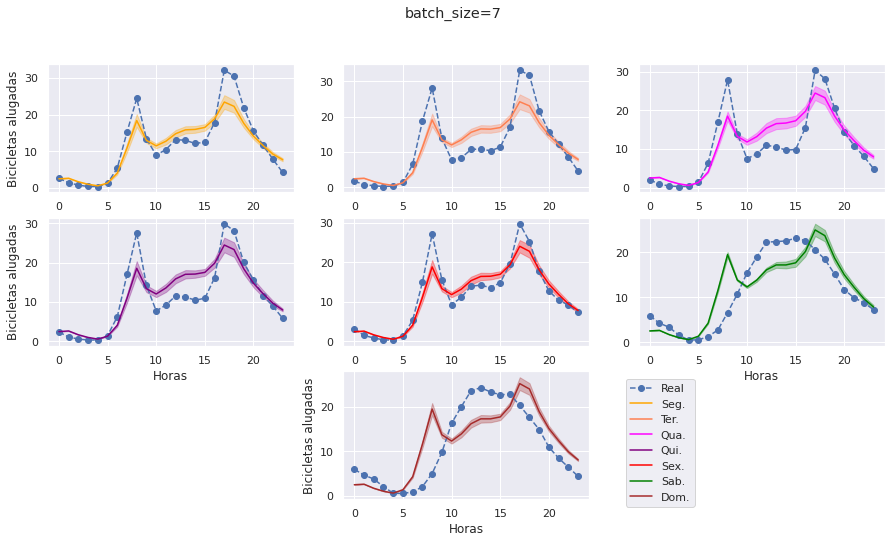

In [16]:
path_lista_fakes = glob.glob("datasets/generated/timegan/2/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes, dict_weeks_real, bbox=(1.45, -0.1), figtitle="batch_size=7")

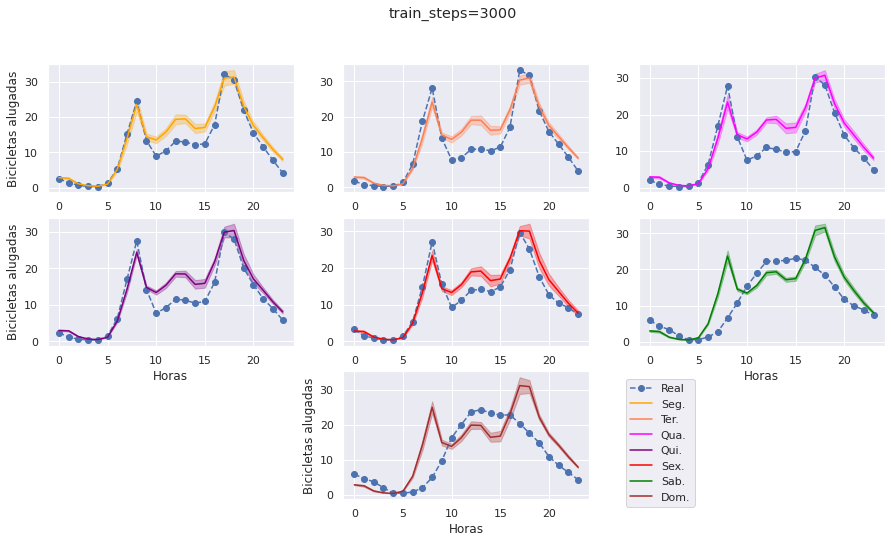

In [17]:
path_lista_fakes = glob.glob("datasets/generated/timegan/3/*.npy")
dict_weeks_fakes = {i:p.get_list_wks(path_lista_fakes, lista_datas[:365*24], 24, wk=i) for i in range(7)}
p.plot_compare_sum(dict_weeks_fakes,dict_weeks_real, bbox=(1.45, -0.1), figtitle="train_steps=3000")

## Treinamento

## Avaliação

In [46]:
import residuals as r
importlib.reload(r)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [31]:
rnn_model = r.make_rnn_model(units=32, n_layers=2, net_type='lstm')

2022-07-06 10:51:29.282348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 10:51:29.282375: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 10:51:29.282399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iranlprm): /proc/driver/nvidia/version does not exist


In [27]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 24, 32)            4352      
                                                                 
 LSTM_2 (LSTM)               (None, 32)                8320      
                                                                 
 OUT (Dense)                 (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [32]:
opt = Adam(learning_rate=5e-4)
rnn_model.compile(optimizer=opt, loss='mse')

In [35]:
X, Y = r.split_sequence(treino_s.flatten(),24)
X = X.reshape(X.shape[0],X.shape[1],1)

In [36]:
early_stop = EarlyStopping(monitor='loss')

In [38]:
hist=rnn_model.fit(X,Y,epochs=50,batch_size=28,callbacks=[early_stop])

Epoch 1/50
312/312 [==============================] - 8s 15ms/step - loss: 0.0317
Epoch 2/50
312/312 [==============================] - 5s 17ms/step - loss: 0.0165


In [39]:
synth_m1 = glob.glob("datasets/generated/timegan/1/*.npy")
synth_m2 = glob.glob("datasets/generated/timegan/2/*.npy")
synth_m3 = glob.glob("datasets/generated/timegan/3/*.npy")

In [40]:
X_pred = rnn_model.predict(X)

273/273 [==============================] - 2s 6ms/step


In [41]:
%%time
reid_m1 = [r.get_residuals(f, X_pred) for f in synth_m1]
reid_m2 = [r.get_residuals(f, X_pred) for f in synth_m2]
reid_m3 = [r.get_residuals(f, X_pred) for f in synth_m3]
resid_arima = res.resid

CPU times: user 1.36 s, sys: 1.38 s, total: 2.74 s
Wall time: 3.1 s


In [42]:
%%time
dict_resid = {
    'mu': [ np.mean(resid_arima),  np.mean(reid_m1), np.mean(reid_m2), np.mean(reid_m3)],
    'std': [np.std(resid_arima), np.std(reid_m1), np.std(reid_m2), np.std(reid_m3)]
}

CPU times: user 10.3 s, sys: 4.59 s, total: 14.9 s
Wall time: 16.1 s


In [43]:
df_resid = pd.DataFrame(dict_resid, index=['arima', 'm1', 'm2', 'm3'])

In [44]:
df_resid

,mu,std
arima,-0.008845,64.608229
m1,0.043540,0.197042
m2,-0.012750,0.247794
m3,-0.048837,0.276025


In [27]:
res.resid.mean()

-0.00884502621089828

In [28]:
res.resid.std()

64.60822861039522